<a href="https://colab.research.google.com/github/Mikalaj-Plck/Data_parsing/blob/main/GB_Attestation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import numpy as np

In [47]:
from sklearn.datasets import fetch_20newsgroups

# Загрузка всего датасета
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

In [48]:
import pandas as pd

categories = ['comp.graphics', 'sci.med']
newsgroups_subset = fetch_20newsgroups(subset='all',
                                     categories=categories,
                                     remove=('headers', 'footers', 'quotes'))
# Создание рабочего DataFrame
df = pd.DataFrame({
    'text': newsgroups_subset.data,
    'category': [categories[target] for target in newsgroups_subset.target]
})

In [49]:
df.head()

,text,category
0,\nYou certainly do not see OTC preparations ad...,sci.med
1,"Hi all,\n\n I am looking for a recommandation...",comp.graphics
2,"\n\nObviously, it wouldn't be of much help to ...",sci.med
3,\nCase Western Reserve Med School teaches nutr...,sci.med
4,"\nYes, absolutely, though I'd make the observa...",sci.med


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1963 entries, 0 to 1962
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      1963 non-null   object
 1   category  1963 non-null   object
dtypes: object(2)
memory usage: 30.8+ KB


In [51]:
# замена строковых данных category на числовые
df['category'] = df['category'].replace({'sci.med': 0, 'comp.graphics': 1})

<ipython-input-51-4270423c54c7>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['category'] = df['category'].replace({'sci.med': 0, 'comp.graphics': 1})


In [52]:
df.head()

,text,category
0,\nYou certainly do not see OTC preparations ad...,0
1,"Hi all,\n\n I am looking for a recommandation...",1
2,"\n\nObviously, it wouldn't be of much help to ...",0
3,\nCase Western Reserve Med School teaches nutr...,0
4,"\nYes, absolutely, though I'd make the observa...",0


<Axes: >

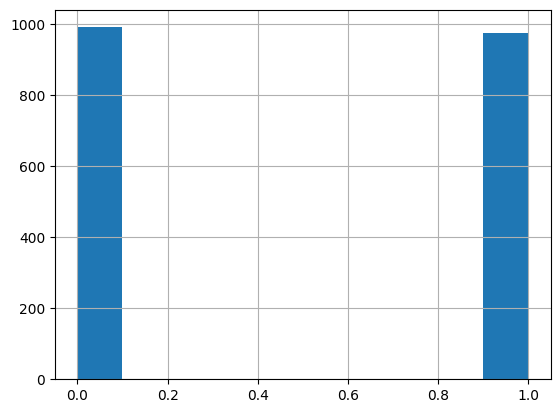

In [53]:
df['category'].hist()

In [54]:
# перетасовываем данные в DF
df = shuffle(df)

In [55]:
# делим на обучающий и тестовый DF
train_df, test_df = train_test_split(df, train_size=0.2, random_state=51)

In [56]:
train_df.head()

,text,category
665,=Which was why I started checking EVERY time I...,0
1248,I experienced a sudden numbness in my left arm...,0
355,"Unfortonately, that truly is about the best su...",0
1109,\n: I'm trying out the C++ graphics package In...,1
305,"Hi,\n\nI'm hoping someone out there will be ab...",1


In [57]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 665 to 1140
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      392 non-null    object
 1   category  392 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.2+ KB


In [58]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1571 entries, 868 to 40
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      1571 non-null   object
 1   category  1571 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 36.8+ KB


In [59]:
# функция модели машинного обучения
def train_model(train_df):
  vectorizer = TfidfVectorizer()
  X = vectorizer.fit_transform(train_df['text'])
  y = train_df['category']
  model = LogisticRegression()
  model.fit(X, y)
  return vectorizer, model

In [60]:
# обучаем модель на учебном DF
vectorizer, model = train_model(train_df)

In [61]:
# пропускаем модель на тестовом DF
X_test = vectorizer.transform(test_df['text'])
y_test_predicted = model.predict(X_test)

In [62]:
# выявляем неопределенность предсказаний
y_test_proba = model.predict_proba(X_test)
uncertainity = -(y_test_proba * np.log2(y_test_proba)).sum(axis=1)

In [63]:
# выбираем данные с наибольшей неопределенностью
train_new = test_df.iloc[uncertainity.argsort()[:100]]

In [64]:
# формируем CSV файл для ручной маркировки
train_new.to_csv('train_new.csv', index=False)

In [65]:
# загружаем промаркированный вручную файл в Label Studio с формированием нового DF
train_new_labeled = pd.read_csv('/content/train_new_labeled.csv', engine='python', on_bad_lines='skip')

In [66]:
# выбираем информативные данные из датасета, которые будут использоваться для вторичного обучения
train_new_labeled = train_new_labeled[['text', 'sentiment']]

In [67]:
# удаляем неинформативную строку
train_new_labeled = train_new_labeled.drop(train_new_labeled.index[0])

In [68]:
# стандартизируем названия столбцов в датасете и заменяем маркировку на цифровые значения
train_new_labeled = train_new_labeled.rename(columns={'sentiment': 'category'})
train_new_labeled['category'] = train_new_labeled['category'].replace({'sci.med': 0, 'comp.graphics': 1})

<ipython-input-68-a2ae7fc12e04>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_new_labeled['category'] = train_new_labeled['category'].replace({'sci.med': 0, 'comp.graphics': 1})


In [69]:
train_new_labeled

,text,category
1,"GREAT post Martin. Very informative, well-bal...",0
2,"\n The following is from a critique of a ""60...",0
3,I can not believe the way this thread on candi...,0
4,Archive-name: graphics/resources-list/part1\nL...,1
5,Archive-name: graphics/resources-list/part1\nL...,1
...,...,...
96,"\nWell, let me put it this way, based on my ow...",0
97,Archive-name: jpeg-faq\nLast-modified: 16 May ...,1
98,"Hi there!...\n\t\tWell, i have a 386/40 with S...",1
99,==============================================...,1


In [70]:
# объединяем тренировочный датасет с промаркированным
train_df = pd.concat([train_df, train_new_labeled])
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 492 entries, 665 to 100
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      492 non-null    object
 1   category  492 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.5+ KB


In [71]:
# переобучаем модель на дополненном DF
vectorizer, model = train_model(train_df)

In [72]:
# Оценка модели на тестовом датасете
X_test = vectorizer.transform(test_df['text'])
y_test_predicted = model.predict(X_test)
f1 = f1_score(test_df['category'], y_test_predicted)

print(f1)

0.8636363636363636
